# 0.0 IMPORTS

In [52]:
import inflection
import math
import datetime

import pandas as pd
import numpy  as np
import seaborn as sns

from scipy import stats as ss
from matplotlib      import pyplot as plt
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image

## 0.1. Helper Functions

In [53]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 50
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
jupyter_settings

<function __main__.jupyter_settings()>

## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  
#promo_interval                  
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [14]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

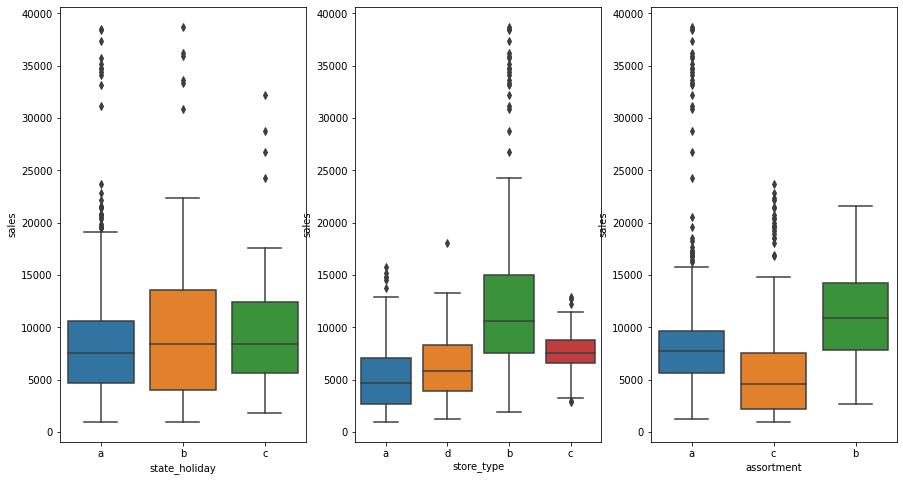

In [16]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

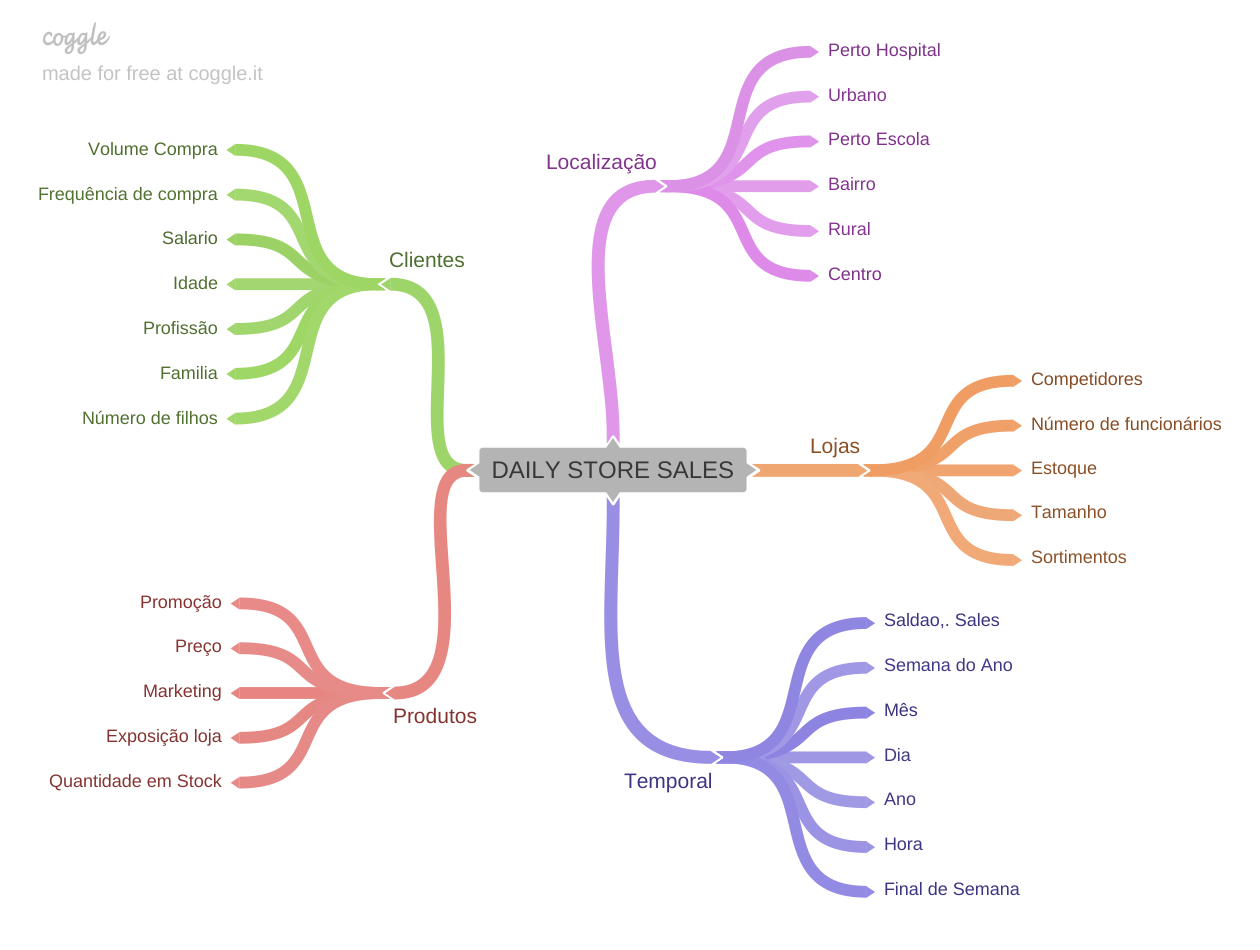

In [18]:
Image('img/MindMapHyphotisis.png')

## 2.2. Criação das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3.Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else  'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\Lucas\AppData\Local\Temp\ipykernel_23620\3409421982.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. FILTRAGEM DE VARIAVEIS

In [20]:
df3 = df2.copy()

## 3.1. Filtragem de Linhas

In [21]:
df3 = df3[(df3['open'] > 0) & (df3['sales'] > 0)]


## 3.2. Seleção das Colunas

In [22]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3.drop(cols_drop, axis=1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [23]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1 Response Variable

c:\users\lucas\resp\rossmann\rossmann\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

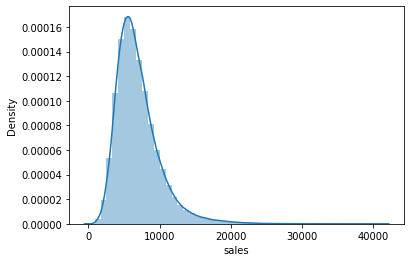

In [24]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

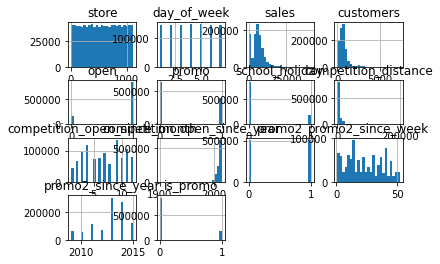

In [25]:
num_attributes.hist(bins=25)

### 4.1.3. Categorical Variable

c:\users\lucas\resp\rossmann\rossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lucas\resp\rossmann\rossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\lucas\resp\rossmann\rossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

<AxesSubplot:xlabel='sales', ylabel='Density'>

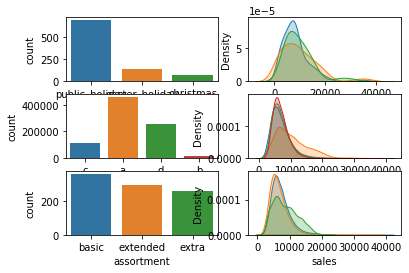

In [26]:
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3 ,2 ,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3, 2, 5)
sns.countplot(a['assortment'])

plt.subplot(3, 2, 6)

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)



## 4.2. Análise Bivariada

### 4.2.1 H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.


<AxesSubplot:xlabel='year_week'>

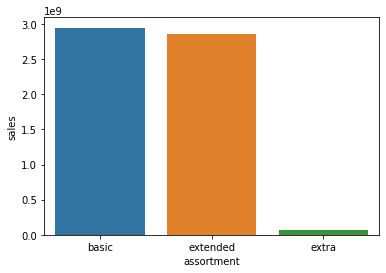

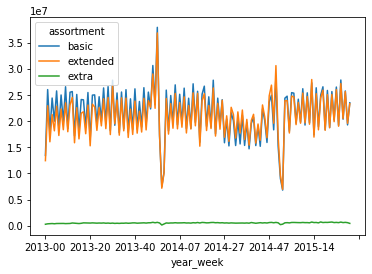

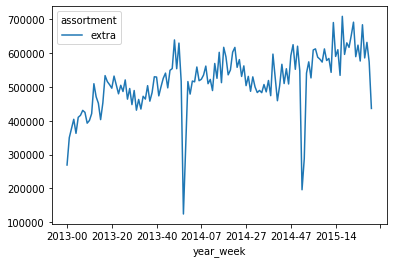

In [27]:
#barplot
aux = df4[['sales', 'assortment']].groupby('assortment').sum().reset_index()
sns.barplot(x=aux['assortment'], y=aux['sales'], data=aux)

#lineplot
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### 4.2.2 H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.


<AxesSubplot:>

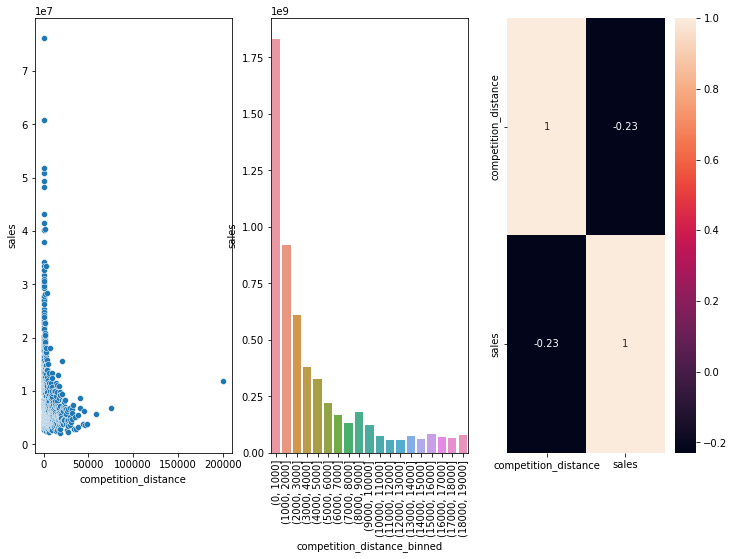

In [28]:

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 4.2.3 H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.


<AxesSubplot:>

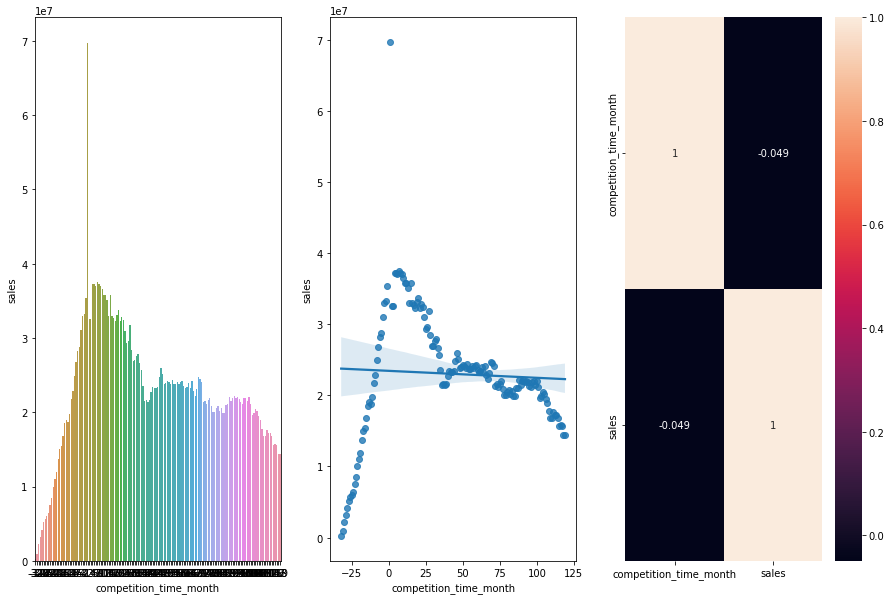

In [29]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True)

### 4.2.4 H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

<AxesSubplot:>

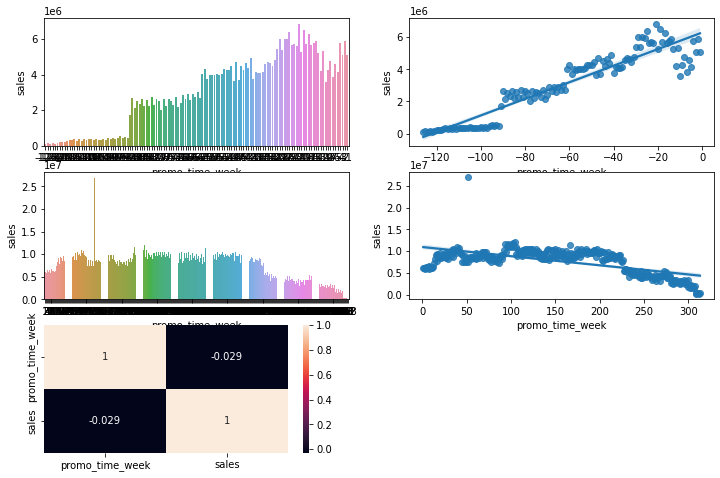

In [30]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
aux2 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(3, 2, 2)
sns.regplot(x='promo_time_week', y='sales', data=aux2)


plt.subplot(3, 2, 3)
aux3 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(3, 2, 4)
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(3, 2, 5)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 4.2.5 <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>


### 4.2.6 H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos


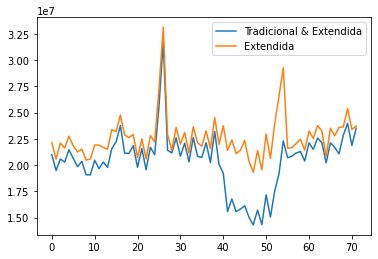

In [31]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax= ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### 4.2.7 H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.


<AxesSubplot:xlabel='year', ylabel='sales'>

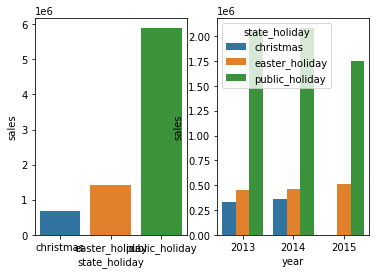

In [32]:
plt.subplot(1, 2,  1)
aux = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 2, 2)
aux1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux1)


### 4.2.8 H9. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos


<AxesSubplot:>

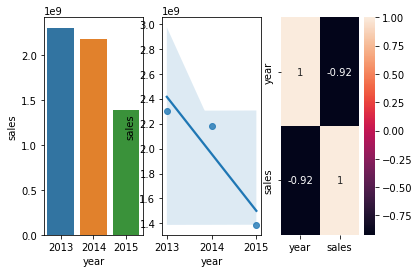

In [33]:
plt.subplot(1, 3, 1)
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

### 4.2.9 H10. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

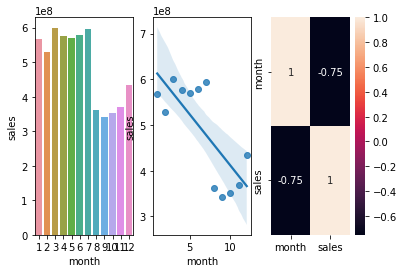

In [34]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 4.2.10 H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.


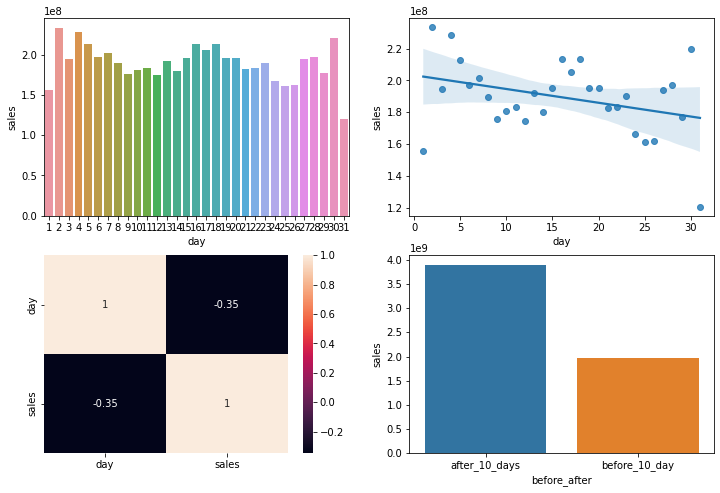

In [35]:
plt.figure(figsize=(12,8))
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux);

plt.subplot(2, 2, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)

aux['before_after'] = aux['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_days')
aux1 = aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux1);

### 4.2.11 H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

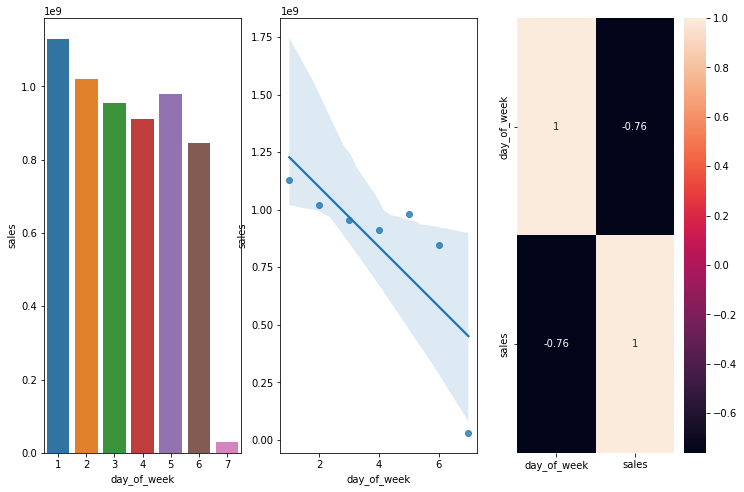

In [36]:
plt.figure(figsize=(12,8))
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 4.2.12 H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.


<AxesSubplot:xlabel='month', ylabel='sales'>

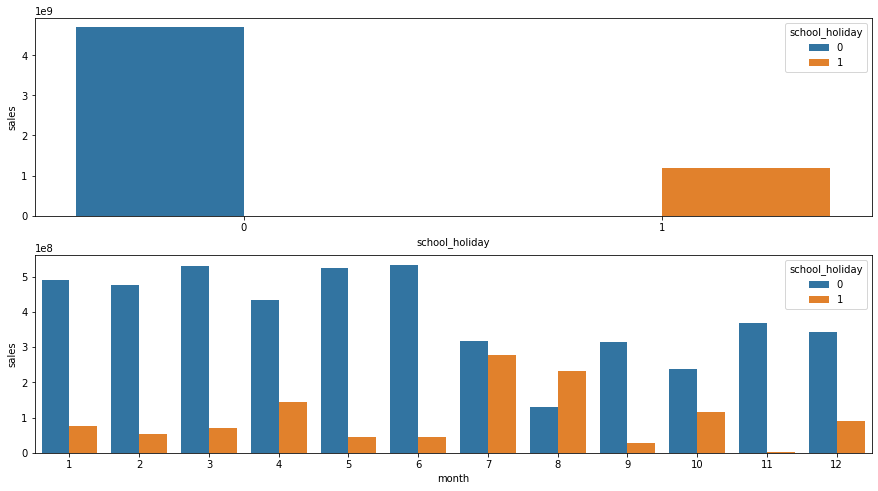

In [37]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', hue='school_holiday', data=aux);

plt.subplot(2, 1, 2)
aux1 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1)

### 4.2.1. Resumo das Hipoteses

In [38]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'],
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

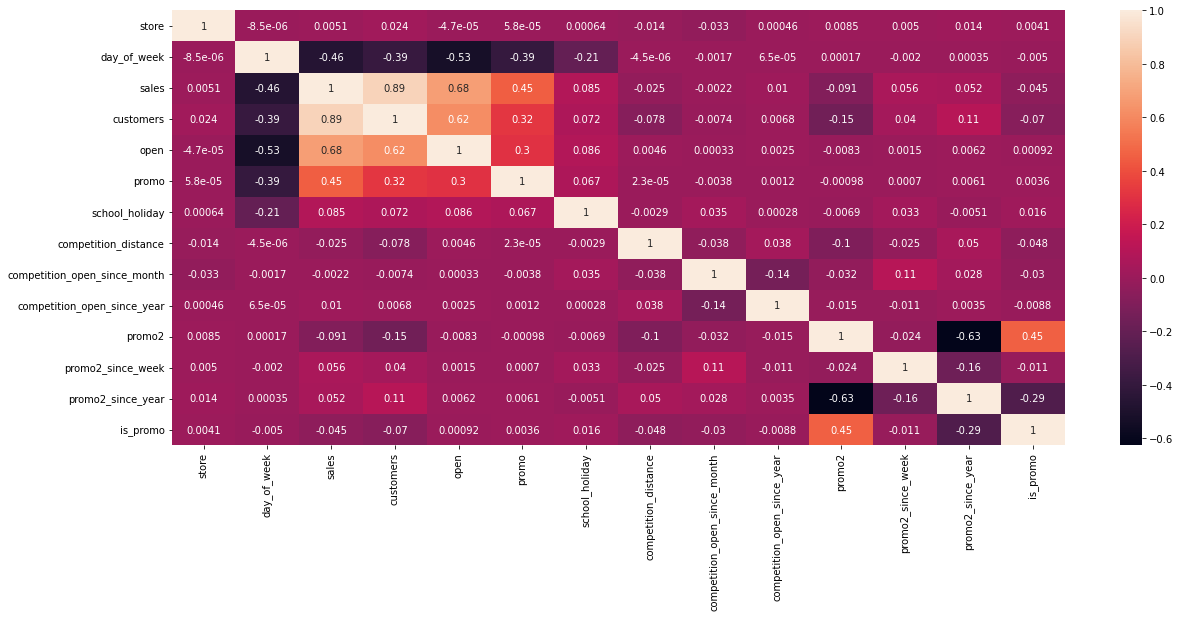

In [41]:
plt.figure(figsize=(20, 8))
sns.heatmap(num_attributes.corr(method='pearson'), annot=True)

### 4.3.2 Categorical Attributes

In [48]:
cat_attributes = df4.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

In [55]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


<AxesSubplot:>

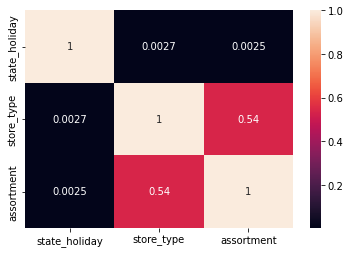

In [62]:
a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type'])
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]
                 })

d = d.set_index(d.columns)
d

sns.heatmap(d, annot=True)